In [1]:
# dbName = "app_member"https://cintell.foresight.healtheintent.com/user/ak055384/notebooks/Users/ak055384/Document%20References/document-explore.ipynb#

# import foresight.database_util
# # Using default version will get latest version for each table, since medicationdispenses is not same version as other tables
# foresight.database_util.use_database(spark, dbName)

# from foresight.discern import with_discern_context
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import concat, col, lit
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import  shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pd.options.display.min_rows = 100
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 5000
import pandas.util.testing as tm

In [2]:
import pickle
from sklearn.manifold import TSNE
import csv
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from functools import partial

In [3]:
spark = SparkSession.builder \
                    .config('spark.dynamicAllocation.maxExecutors', '400') \
                    .config('spark.executor.cores', '5') \
                    .config('spark.sql.shuffle.partitions', '2000') \
                    .config('spark.driver.maxResultSize','40g') \
                    .getOrCreate()

In [4]:
# Location of the discernontology database
from foresight.discern import broadcast_discern, push_discern, pop_discern
root = 's3://cintell-datalab-persistence-s3-data/discernontology/v1/'

contextid = ['A092E06F76904ACEA678885913A35D46']

#Loop that removes all hypthens and captializes all letters. Setups up file location
for contextid in contextid:
    contextid = contextid.upper().replace("-", "")
    push_discern(spark, contextid, discern_root=root)
    
    print(contextid)

A092E06F76904ACEA678885913A35D46


In [5]:
!pip install mlxtend  

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [6]:
spark.sql('use intermountain_member')
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,intermountain_member,advancedirectives,False
1,intermountain_member,allergies,False
2,intermountain_member,appointments,False
3,intermountain_member,calculatedriskscores,False
4,intermountain_member,careplans,False
5,intermountain_member,claims,False
6,intermountain_member,cmsdrgs,False
7,intermountain_member,cmsmembersinfo,False
8,intermountain_member,communications,False
9,intermountain_member,conditions,False


In [7]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [8]:
# Show database being used.
spark.sql("SELECT CURRENT_DATABASE()").toPandas()

,current_database()
0,intermountain_member


In [9]:
import foresight.database_util

dbName = "intermountain_member"
versionDF = spark.sql(F"""select max(version) as versionNumber from {dbName}.encounters order by 1 """).toPandas()
versionNumber =  versionDF.versionNumber[0] 
versionNumber = str(versionNumber) + ".0"
versionNumber = versionNumber.replace(' ', 'T')
print(versionNumber)

foresight.database_util.use_database(spark, dbName, versionNumber)

2020-05-31T20:10:00.0


In [10]:
versionDF = spark.sql(F"""select max(version) as versionNumber from {dbName}.documentreferences order by 1 """).toPandas()
versionNumber =  versionDF.versionNumber[0] 
versionNumber = str(versionNumber) + ".0"
versionNumber = versionNumber.replace(' ', 'T')
print(versionNumber)

foresight.database_util.use_database(spark, dbName, versionNumber)

2020-05-31T20:10:00.0


In [11]:
defaultcontext = 'A092E06F76904ACEA678885913A35D46'
defaultcontext

'A092E06F76904ACEA678885913A35D46'

In [12]:
DocumentTypes = """ADMINISTRATIVE_NOTE_OBSTYPE', 'BONE_DENSITY_REPORT_OBSTYPE', 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE', 'CARDIOLOGY_REPORT_OBSTYPE', 'CARE_MANAGER_NOTE_OBSTYPE', 'CLINICAL_NOTE_OBSTYPE','CLINICAL_NOTE_IP_OP_OBSTYPE', 'CONSULTATION_NOTE_OBSTYPE', 'CT_REPORT_OBSTYPE','CYTOLOGY_REPORT_OBSTYPE', 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE', 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE','ECG_REPORT_OBSTYPE','ECHO_REPORT_OBSTYPE','ELECTRON_MICROSCOPY_REPORT_OBSTYPE','ENDOSCOPY_REPORT_OBSTYPE','FLUOROSCOPY_REPORT_OBSTYPE','H_AND_P_NOTE_OBSTYPE','HEMATOLOGY_REPORT_OBSTYPE','IMMUNIZATION_RECORD_OBSTYPE','IMMUNIZATION_SUMMARY_REPORT_OBSTYPE','IR_REPORT_OBSTYPE','MAMMOGRAPHY_REPORT_OBSTYPE','MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE','MICROBIOLOGY_REPORT_OBSTYPE', 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE', 'MR_REPORT_OBSTYPE','NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE','NURSE_NOTE_OBSTYPE','PATHOLOGY_REPORT_OBSTYPE','PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE','PET_SCAN_REPORT_OBSTYPE', 'PHONE_ENCOUNTER_NOTE_OBSTYPE','PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE','PROCEDURE_SURGERY_NOTE_OBSTYPE','RADIOLOGY_REPORT_OBSTYPE','REFERRAL_NOTE_OBSTYPE','RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE','SUMMARY_DOCUMENT_OBSTYPE','THERAPY_NOTE_OBSTYPE','US_ULTRASOUND_REPORT_OBSTYPE','VA_C_P_DOCUMENT_OBSTYPE','XR_REPORT_OBSTYPE"""
DocumentTypes

"ADMINISTRATIVE_NOTE_OBSTYPE', 'BONE_DENSITY_REPORT_OBSTYPE', 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE', 'CARDIOLOGY_REPORT_OBSTYPE', 'CARE_MANAGER_NOTE_OBSTYPE', 'CLINICAL_NOTE_OBSTYPE','CLINICAL_NOTE_IP_OP_OBSTYPE', 'CONSULTATION_NOTE_OBSTYPE', 'CT_REPORT_OBSTYPE','CYTOLOGY_REPORT_OBSTYPE', 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE', 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE','ECG_REPORT_OBSTYPE','ECHO_REPORT_OBSTYPE','ELECTRON_MICROSCOPY_REPORT_OBSTYPE','ENDOSCOPY_REPORT_OBSTYPE','FLUOROSCOPY_REPORT_OBSTYPE','H_AND_P_NOTE_OBSTYPE','HEMATOLOGY_REPORT_OBSTYPE','IMMUNIZATION_RECORD_OBSTYPE','IMMUNIZATION_SUMMARY_REPORT_OBSTYPE','IR_REPORT_OBSTYPE','MAMMOGRAPHY_REPORT_OBSTYPE','MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE','MICROBIOLOGY_REPORT_OBSTYPE', 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE', 'MR_REPORT_OBSTYPE','NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE','NURSE_NOTE_OBSTYPE','PATHOLOGY_REPORT_OBSTYPE','PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE','PET_SCAN_REPORT_OBSTYPE', 'PHONE_ENCOUNTER_NOTE_OBSTYPE

In [13]:
documents_concat =  spark.sql(F"""select dr.encounterId,
                              collect_set(date_format(dr.serviceDate, 'yyyy-MM-dd')) as DocServiceDate,
                              collect_set(e.classification.standard.primaryDisplay) as EncounterType,
                              collect_set(e.admissionSource.standard.primaryDisplay) as EncounterAdmissionSource,
                              collect_set(e.admissionType.standard.primaryDisplay) as EncounterAdmissionType,
                              collect_set(locations[0].facility.name) as LocationFacility, 
                              collect_set(locations[0].building.name) as LocationBuilding, 
                              collect_set(locations[0].nurseUnit.name) as LocationNurseUnit,
                              collect_set(date_format(e.serviceDate, 'yyyy-MM-dd')) AS EncounterRegistrationDate,
                              collect_set(date_format(e.dischargeDate, 'yyyy-MM-dd')) AS EncounterDischargeDate,
                              collect_set(CASE WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ADMINISTRATIVE_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'ADMINISTRATIVE_NOTE_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('BONE_DENSITY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'BONE_DENSITY_REPORT_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARDIAC_CATHETERIZATION_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARE_MANAGER_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CARE_MANAGER_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARDIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CARDIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CLINICAL_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CLINICAL_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CLINICAL_NOTE_IP_OP_OBSTYPE'), '{defaultcontext}' ) THEN 'CLINICAL_NOTE_IP_OP_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CONSULTATION_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CONSULTATION_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CT_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CT_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CYTOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CYTOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('DIAGNOSTIC_IMAGING_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ECG_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ECG_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ECHO_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ECHO_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ELECTRON_MICROSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ELECTRON_MICROSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ENDOSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ENDOSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('FLUOROSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'FLUOROSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('H_AND_P_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'H_AND_P_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('HEMATOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'HEMATOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IMMUNIZATION_RECORD_OBSTYPE'), '{defaultcontext}' ) THEN 'IMMUNIZATION_RECORD_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IMMUNIZATION_SUMMARY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'IMMUNIZATION_SUMMARY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'IR_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MAMMOGRAPHY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MAMMOGRAPHY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MICROBIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MICROBIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MR_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('NURSE_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'NURSE_NOTE_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PATHOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PATHOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PET_SCAN_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PET_SCAN_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PHONE_ENCOUNTER_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PHONE_ENCOUNTER_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PROCEDURE_SURGERY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PROCEDURE_SURGERY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('RADIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'RADIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('REFERRAL_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'REFERRAL_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('SUMMARY_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'SUMMARY_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('THERAPY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'THERAPY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('US_ULTRASOUND_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'US_ULTRASOUND_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('VA_C_P_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'VA_C_P_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('XR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'XR_REPORT_OBSTYPE' 
                                   ELSE NULL
                              END) AS DiscernDocumentType,
                              collect_set(dr.type.standard.primaryDisplay) AS StandardDocumentType
                          FROM {dbName}_documentreferences dr
                        JOIN {dbName}_encounters e ON dr.encounterId = e.encounterId
                          WHERE HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('{DocumentTypes}'),'{defaultcontext}')
                          and e.classification.standard.primaryDisplay IS NOT NULL
                          and e.dischargeDate IS NOT NULL
                          and e.admissionType.standard.primaryDisplay IS NOT NULL
                          and locations[0].nurseUnit.name IS NOT NULL
                          and e.classification.standard.primaryDisplay in ('Outpatient', 'Emergency', 'Preadmit')
                          GROUP BY dr.encounterId
                          HAVING size(StandardDocumentType) <= 5
                          limit 1500000""").toPandas()
documents_concat.head()

,encounterId,DocServiceDate,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationFacility,LocationBuilding,LocationNurseUnit,EncounterRegistrationDate,EncounterDischargeDate,DiscernDocumentType,StandardDocumentType
0,25715946,[2015-03-04],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Logan],[zzzLG_SS_ENDO_Hold],[2015-03-04],[2015-03-04],"[ENDOSCOPY_REPORT_OBSTYPE, PATHOLOGY_REPORT_OBSTYPE, CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]"
1,25833853,[2015-02-24],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Med Art Bldg],[LG_Budge Lab],[2015-02-24],[2015-02-25],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
2,25857613,[2015-03-01],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-01],[2015-03-01],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
3,25858962,[2015-03-02],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-02],[2015-03-02],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
4,25873399,[2015-03-02],[Outpatient],[Information not available],[Unknown],[LG_Logan],[LG_Logan],[LG_Main Lab],[2015-03-02],[2015-03-03],[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]


In [14]:
documents_concat.shape

(1500000, 12)

In [15]:
documents_concat.head()

,encounterId,DocServiceDate,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationFacility,LocationBuilding,LocationNurseUnit,EncounterRegistrationDate,EncounterDischargeDate,DiscernDocumentType,StandardDocumentType
0,25715946,[2015-03-04],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Logan],[zzzLG_SS_ENDO_Hold],[2015-03-04],[2015-03-04],"[ENDOSCOPY_REPORT_OBSTYPE, PATHOLOGY_REPORT_OBSTYPE, CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]"
1,25833853,[2015-02-24],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Med Art Bldg],[LG_Budge Lab],[2015-02-24],[2015-02-25],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
2,25857613,[2015-03-01],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-01],[2015-03-01],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
3,25858962,[2015-03-02],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-02],[2015-03-02],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
4,25873399,[2015-03-02],[Outpatient],[Information not available],[Unknown],[LG_Logan],[LG_Logan],[LG_Main Lab],[2015-03-02],[2015-03-03],[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]


In [16]:
(documents_concat.drop(columns=['DocServiceDate','EncounterRegistrationDate','LocationFacility','EncounterDischargeDate'],
                      inplace=True))

In [17]:
documents_concat['EncounterType'] = documents_concat['EncounterType'].str[0]
documents_concat['EncounterAdmissionSource'] = documents_concat['EncounterAdmissionSource'].str[0]
documents_concat['EncounterAdmissionType'] = documents_concat['EncounterAdmissionType'].str[0]
documents_concat['LocationBuilding'] = documents_concat['LocationBuilding'].str[0]
documents_concat['LocationNurseUnit'] = documents_concat['LocationNurseUnit'].str[0]

In [18]:
documents_concat.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25715946,Outpatient,Clinic referral,Elective,LG_Logan,zzzLG_SS_ENDO_Hold,"[ENDOSCOPY_REPORT_OBSTYPE, PATHOLOGY_REPORT_OBSTYPE, CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]"
1,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
2,25857613,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
3,25858962,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
4,25873399,Outpatient,Information not available,Unknown,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]


In [19]:
documents_concat.isnull().sum()

encounterId                    0
EncounterType                  0
EncounterAdmissionSource    8433
EncounterAdmissionType         0
LocationBuilding               0
LocationNurseUnit              0
DiscernDocumentType            0
StandardDocumentType           0
dtype: int64

In [20]:
documents_concat.describe()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
count,1500000,1500000,1491567,1500000,1500000,1500000,1500000,1500000
unique,1500000,3,7,6,397,1614,86,5542
top,38330607,Outpatient,Clinic referral,Elective,MK_McKay-Dee,CL_ORPDS,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
freq,1,1190445,1030371,1179376,139264,104293,801766,795691


In [21]:
documents_final = documents_concat.loc[documents_concat['encounterId'] != '0']

In [22]:
documents_final.shape

(1500000, 8)

In [23]:
documents_final = documents_concat.loc[documents_concat['EncounterAdmissionSource'].notnull()]

In [24]:
documents_final.shape

(1491567, 8)

In [25]:
documents_final.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25715946,Outpatient,Clinic referral,Elective,LG_Logan,zzzLG_SS_ENDO_Hold,"[ENDOSCOPY_REPORT_OBSTYPE, PATHOLOGY_REPORT_OBSTYPE, CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]"
1,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
2,25857613,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
3,25858962,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
4,25873399,Outpatient,Information not available,Unknown,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]


In [26]:
documents_final_standard = documents_final[['encounterId', 'StandardDocumentType']]
documents_final_standard.shape

(1491567, 2)

In [27]:
documents_final.isnull().sum()

encounterId                 0
EncounterType               0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
DiscernDocumentType         0
StandardDocumentType        0
dtype: int64

In [28]:
documents_final = documents_final.loc[documents_final['EncounterAdmissionSource'] != 'Information not available']

In [29]:
documents_final.shape

(1491072, 8)

In [30]:
documents_final = documents_final.loc[documents_final['EncounterAdmissionType'] != 'Unknown']

In [31]:
documents_final.shape

(1491071, 8)

In [32]:
documents_final['EncounterAdmissionType'].value_counts()

Elective                                  1171035
Urgent                                     234336
Emergency                                   84156
Accident                                     1526
Newborn (Birth in healthcare facility)         18
Name: EncounterAdmissionType, dtype: int64

In [33]:
documents_final['EncounterAdmissionSource'].value_counts()

Clinic referral                                     1030370
Hospital admission from non-health care facility     456150
Court/law enforcement                                  3154
Transfer from a hospital                                650
Transfer from another health care facility              590
Transfer from a skilled nursing facility                157
Name: EncounterAdmissionSource, dtype: int64

In [34]:
documents_final['LocationBuilding'].value_counts()

MK_McKay-Dee          139173
CL_Outreach           102925
DX_Dixie               78706
AF_Amer Fork           68612
LG_Logan               63559
CC_Cedar City          48687
LG_Med Art Bldg        41079
DX_Health Ctr          40352
IM_9 ED                39218
UV_UVOC                36849
PC_Primary             36378
IM_2 Eccles OP         35991
CL_Q_U_Clnt            34896
UV_Utah Valley         33633
RV_2 Riverton          31859
SV_Sevier              28863
PK_Park City           26222
CA_Cassia              25092
AV_Alta View           23427
LD_6 LDS               21690
UV_Pedersen Twr        21279
CL_G_K                 19569
IM_8 BreastCntr        19346
BR_Bear River          18051
RV_Emergency           17633
CL_Central Lab         17030
HV_Heber               16081
OR_Orem                15887
PC_Eccles OP           15486
DX_Hurricane           13045
TO_TOSH                12538
DX_400 E Campus        11508
LD_7 Emergency         11272
CL_V_Z                 11186
SP_Sanpete    

In [35]:
documents_final.dtypes

encounterId                 object
EncounterType               object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
DiscernDocumentType         object
StandardDocumentType        object
dtype: object

In [36]:
documents_final['encounterId'] = documents_final['encounterId'].astype(str)
documents_final['EncounterType'] = documents_final['EncounterType'].astype(str)
documents_final['EncounterAdmissionSource'] = documents_final['EncounterAdmissionSource'].astype(str)
documents_final['EncounterAdmissionType'] = documents_final['EncounterAdmissionType'].astype(str)
documents_final['LocationBuilding'] = documents_final['LocationBuilding'].astype(str)
documents_final['LocationNurseUnit'] = documents_final['LocationNurseUnit'].astype(str)

In [37]:
documents_final.isnull().sum()

encounterId                 0
EncounterType               0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
DiscernDocumentType         0
StandardDocumentType        0
dtype: int64

In [38]:
documents_final.shape

(1491071, 8)

In [39]:
documents_final.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25715946,Outpatient,Clinic referral,Elective,LG_Logan,zzzLG_SS_ENDO_Hold,"[ENDOSCOPY_REPORT_OBSTYPE, PATHOLOGY_REPORT_OBSTYPE, CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]"
1,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
5,26095725,Outpatient,Clinic referral,Elective,LG_Logan,LG_US,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
6,26141171,Outpatient,Clinic referral,Elective,LG_Logan,LG_CT,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
7,26159446,Outpatient,Clinic referral,Elective,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]


In [40]:
documents_final_standard = ( documents_final[['encounterId', 
                                                'EncounterType', 
                                                'StandardDocumentType', 
                                                'EncounterAdmissionSource',
                                                'EncounterAdmissionType',
                                                'LocationBuilding',
                                                'LocationNurseUnit']])

In [41]:
documents_final_standard['encounterId'] = documents_final_standard['encounterId'].astype(str)
documents_final_standard['EncounterType'] = documents_final_standard['EncounterType'].astype(str)
documents_final_standard['EncounterAdmissionSource'] = documents_final_standard['EncounterAdmissionSource'].astype(str)
documents_final_standard['EncounterAdmissionType'] = documents_final_standard['EncounterAdmissionType'].astype(str)
documents_final_standard['LocationBuilding'] = documents_final_standard['LocationBuilding'].astype(str)
documents_final_standard['LocationNurseUnit'] = documents_final_standard['LocationNurseUnit'].astype(str)

In [42]:
documents_final_standard.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25715946,Outpatient,"[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]",Clinic referral,Elective,LG_Logan,zzzLG_SS_ENDO_Hold
1,25833853,Outpatient,[Consent Document],Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab
5,26095725,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_US
6,26141171,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_CT
7,26159446,Outpatient,[Surgical pathology study],Clinic referral,Elective,LG_Logan,LG_Main Lab


In [43]:
transactions = list(documents_final_standard['StandardDocumentType'])

In [44]:
encoder = TransactionEncoder().fit(transactions)

In [45]:
onehot = encoder.transform(transactions)

In [46]:
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

In [47]:
onehot.shape

(1491071, 222)

In [48]:
documents_final_standard.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [49]:
documents_final_standard.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25715946,Outpatient,"[Colonoscopy study, Discharge instructions, Anesthesiology Note, Surgical pathology study, Consent Document]",Clinic referral,Elective,LG_Logan,zzzLG_SS_ENDO_Hold
1,25833853,Outpatient,[Consent Document],Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab
5,26095725,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_US
6,26141171,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_CT
7,26159446,Outpatient,[Surgical pathology study],Clinic referral,Elective,LG_Logan,LG_Main Lab


In [50]:
onehot.head()

,Advance directives,Allergy and Immunology Consult note,Allergy and Immunology Outpatient Note,Allergy and Immunology Progress note,Allergy and Immunology procedure note,Anesthesiology Consult note,Anesthesiology Note,Anesthesiology Postoperative evaluation and management note,Anesthesiology Preoperative evaluation and management note,Anesthesiology procedure note,...,Urgent care center Note,Urology Consult note,Urology Outpatient Note,Urology Outpatient procedure note,Urology Progress note,Vascular surgery Consult note,Vascular surgery Outpatient Note,Vascular surgery procedure note,Well child visit note,Wound care management Note
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
encoder.columns_

['Advance directives',
 'Allergy and Immunology Consult note',
 'Allergy and Immunology Outpatient Note',
 'Allergy and Immunology Progress note',
 'Allergy and Immunology procedure note',
 'Anesthesiology Consult note',
 'Anesthesiology Note',
 'Anesthesiology Postoperative evaluation and management note',
 'Anesthesiology Preoperative evaluation and management note',
 'Anesthesiology procedure note',
 'Antepartum summary note',
 'Attending Progress note',
 'Audiology Medical equipment or product note',
 'Audiology Note',
 'Audiology Progress note',
 'Blood banking and transfusion medicine Note',
 'Cardiac catheterization study',
 'Cardiac surgery Consult note',
 'Cardiology Consult note',
 'Cardiology Hospital Progress note',
 'Cardiology Outpatient Note',
 'Cardiology procedure note',
 'Care management note',
 'Clinical genetics Consult note',
 'Clinical genetics Outpatient Note',
 'Clinical pathology Consult note',
 'Colonoscopy study',
 'Consent Document',
 'Consult note',
 'Cytol

In [52]:
documents_final_standard['StandardDocumentType'].explode().value_counts()

Consent Document                                                       1307647
Emergency department Triage note                                        307610
Physician Emergency department Note                                     304215
Nurse Emergency department Note                                         272595
History and physical note                                               120805
Anesthesiology Note                                                      87741
Cardiology procedure note                                                78076
Surgical pathology study                                                 75366
Surgical operation note                                                  62258
Cytology report of Cervical or vaginal smear or scraping Cyto stain      60238
Outpatient Education note                                                38667
Nurse Outpatient Note                                                    30403
Family medicine Progress note                       

In [53]:
documents_final_standard.isnull().sum()

encounterId                 0
EncounterType               0
StandardDocumentType        0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
dtype: int64

In [54]:
documents_final_standard.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [55]:
documents_final_standard['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                                                   793730
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]                                           192877
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                                                 59884
[Surgical pathology study]                                                                                                                                            51320
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Cardiology procedure note, Emergency department Triage note]                 43608
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                                 

In [56]:
documents_final_standard['EncounterAdmissionSource'] = (documents_final_standard['EncounterAdmissionSource']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['EncounterAdmissionType'] = (documents_final_standard['EncounterAdmissionType']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['LocationBuilding'] = (documents_final_standard['LocationBuilding']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['LocationNurseUnit'] = (documents_final_standard['LocationNurseUnit']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))

In [57]:
documents_final_standard.reset_index(drop=True, inplace=True)

In [61]:
top30 = documents_final_standard['StandardDocumentType'].explode().value_counts().nlargest(30)

In [59]:
documents_final_standard['StandardDocumentType'].explode().value_counts().shape[0]

222

In [60]:
top30.index.tolist()

['Consent Document',
 'Emergency department Triage note',
 'Physician Emergency department Note',
 'Nurse Emergency department Note',
 'History and physical note',
 'Anesthesiology Note',
 'Cardiology procedure note',
 'Surgical pathology study',
 'Surgical operation note',
 'Cytology report of Cervical or vaginal smear or scraping Cyto stain',
 'Outpatient Education note',
 'Nurse Outpatient Note',
 'Family medicine Progress note',
 'Procedure note',
 'Discharge instructions',
 'Maternal and fetal medicine Note',
 'Photographic image',
 'Sleep medicine Outpatient Note',
 'Endocrinology Note',
 'Care management note',
 'Education note',
 'Emergency department Note',
 'Oncology Progress note',
 'Cardiology Outpatient Note',
 'Internal medicine Outpatient Note',
 'Endocrinology Outpatient Note',
 'Transfer summary note',
 'Audiology Note',
 'Non-gynecological cytology method study',
 'Pulmonary Outpatient Note']

In [62]:
'|'.join(top30.index.tolist())

'Consent Document|Emergency department Triage note|Physician Emergency department Note|Nurse Emergency department Note|History and physical note|Anesthesiology Note|Cardiology procedure note|Surgical pathology study|Surgical operation note|Cytology report of Cervical or vaginal smear or scraping Cyto stain|Outpatient Education note|Nurse Outpatient Note|Family medicine Progress note|Procedure note|Discharge instructions|Maternal and fetal medicine Note|Photographic image|Sleep medicine Outpatient Note|Endocrinology Note|Care management note|Education note|Emergency department Note|Oncology Progress note|Cardiology Outpatient Note|Internal medicine Outpatient Note|Endocrinology Outpatient Note|Transfer summary note|Audiology Note|Non-gynecological cytology method study|Pulmonary Outpatient Note'

In [63]:
top30.index

Index(['Consent Document', 'Emergency department Triage note',
       'Physician Emergency department Note',
       'Nurse Emergency department Note', 'History and physical note',
       'Anesthesiology Note', 'Cardiology procedure note',
       'Surgical pathology study', 'Surgical operation note',
       'Cytology report of Cervical or vaginal smear or scraping Cyto stain',
       'Outpatient Education note', 'Nurse Outpatient Note',
       'Family medicine Progress note', 'Procedure note',
       'Discharge instructions', 'Maternal and fetal medicine Note',
       'Photographic image', 'Sleep medicine Outpatient Note',
       'Endocrinology Note', 'Care management note', 'Education note',
       'Emergency department Note', 'Oncology Progress note',
       'Cardiology Outpatient Note', 'Internal medicine Outpatient Note',
       'Endocrinology Outpatient Note', 'Transfer summary note',
       'Audiology Note', 'Non-gynecological cytology method study',
       'Pulmonary Outpatient N

In [64]:
documents_final_standard['StandardDocumentType'].dtype

dtype('O')

In [65]:
# document_updated_oupatient_standard_largest = ( documents_final_standard[
#                                         documents_final_standard['StandardDocumentType']
#                                             .str.join(',').str.contains
#                                             ('|'.join(
#                                                 top20.index.tolist()
#                                             ))])

In [66]:
 document_updated_oupatient_standard_largest = ( documents_final_standard[
             documents_final_standard['StandardDocumentType']
     .apply(lambda lst: all(x in top30.index.tolist() for x in lst))])

In [67]:
document_updated_oupatient_standard_largest.shape

(1423125, 7)

In [68]:
document_updated_oupatient_standard_largest['StandardDocumentType'].explode().value_counts().shape[0]

30

In [69]:
document_updated_oupatient_standard_largest.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,1423125,1423125,1423125,1423125,1423125,1423125,1423125
unique,1423125,3,1088,6,5,272,1414
top,38330607,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,1122269,793730,989414,1115445,130538,102113


In [70]:
document_updated_oupatient_standard_largest['EncounterAdmissionSource'].unique()

array(['clinicreferral', 'hospitaladmissionfromnonhealthcarefacility',
       'courtlawenforcement', 'transferfromanotherhealthcarefacility',
       'transferfromaskillednursingfacility', 'transferfromahospital'],
      dtype=object)

In [71]:
document_updated_oupatient_standard_largest['EncounterAdmissionType'].unique()

array(['elective', 'emergency', 'urgent', 'accident',
       'newbornbirthinhealthcarefacility'], dtype=object)

In [72]:
document_updated_oupatient_standard_largest.shape

(1423125, 7)

In [73]:
document_updated_oupatient_standard_largest.describe(include='all')

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,1423125,1423125,1423125,1423125,1423125,1423125,1423125
unique,1423125,3,1088,6,5,272,1414
top,38330607,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,1122269,793730,989414,1115445,130538,102113


In [74]:
document_updated_oupatient_standard_largest.reset_index(drop=True, inplace=True)

In [75]:
top100_multiple = document_updated_oupatient_standard_largest['StandardDocumentType'].value_counts().nlargest(100)

In [76]:
 document_updated_oupatient_standard_multiple = ( document_updated_oupatient_standard_largest[
             document_updated_oupatient_standard_largest['StandardDocumentType']
     .apply(lambda x:  any(x == y for y in top100_multiple.index.tolist()))])

In [77]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [78]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                                       793730
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]                               192877
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                                     59884
[Surgical pathology study]                                                                                                                                51320
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Cardiology procedure note, Emergency department Triage note]     43608
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                                               34104
[Physician Emergency department Note, Co

In [79]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].explode().value_counts()

Consent Document                                                       1238748
Emergency department Triage note                                        294433
Physician Emergency department Note                                     290807
Nurse Emergency department Note                                         263685
History and physical note                                                95839
Anesthesiology Note                                                      74011
Surgical pathology study                                                 70892
Cardiology procedure note                                                70798
Cytology report of Cervical or vaginal smear or scraping Cyto stain      59884
Surgical operation note                                                  54815
Family medicine Progress note                                            26811
Outpatient Education note                                                26041
Procedure note                                      

In [80]:
document_updated_oupatient_standard_multiple.reset_index(drop=True, inplace=True)

In [81]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [82]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [83]:
document_updated_oupatient_standard_multiple.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,1401586,1401586,1401586,1401586,1401586,1401586,1401586
unique,1401586,3,100,6,5,257,1387
top,38330607,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,1105453,793730,975818,1099014,129390,102035


In [84]:
(document_updated_oupatient_standard_multiple.
to_pickle("document_updated_outpatient_standard_multiple_five.pkl.compress", compression="gzip", protocol=4))

In [85]:
document_updated_oupatient_standard_multiple = (pd.read_pickle
                                        ("document_updated_outpatient_standard_multiple_five.pkl.compress", compression="gzip"))

In [86]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [87]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [88]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [89]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [90]:
document_updated_oupatient_standard_multiple.isnull().sum()

encounterId                 0
EncounterType               0
StandardDocumentType        0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
dtype: int64

In [91]:
document_updated_oupatient_standard_multiple.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,1401586,1401586,1401586,1401586,1401586,1401586,1401586
unique,1401586,3,100,6,5,257,1387
top,38330607,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,1105453,793730,975818,1099014,129390,102035


In [92]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                                       793730
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]                               192877
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                                     59884
[Surgical pathology study]                                                                                                                                51320
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Cardiology procedure note, Emergency department Triage note]     43608
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                                               34104
[Physician Emergency department Note, Co

In [93]:
document_updated_oupatient_standard_multiple.reset_index(drop=True, inplace=True)

In [94]:
document_updated_oupatient_standard_multiple.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [95]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [96]:
categories = document_updated_oupatient_standard_multiple['EncounterType'].unique()
categories

array(['Outpatient', 'Emergency', 'Preadmit'], dtype=object)

In [97]:
encoder_outpatient = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [98]:
document_outpatient_types_one_hot_et = (encoder_outpatient.
                            fit_transform(document_updated_oupatient_standard_multiple[['EncounterType']]))

In [99]:
document_outpatient_types_one_hot_et

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [100]:
encoder_outpatient.categories_

[array(['Emergency', 'Outpatient', 'Preadmit'], dtype=object)]

In [101]:
document_outpatient_types_one_hot_et = (pd.DataFrame(document_outpatient_types_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient.categories_, 0)))

In [102]:
document_outpatient_types_one_hot_et.shape

(1401586, 2)

In [103]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [104]:
document_updated_oupatient_standard_multiple.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [105]:
encoder_outpatient_admission_source = OneHotEncoder(drop='first', sparse=False,dtype=np.int)

In [106]:
document_outpatient_admission_source_one_hot_et = (encoder_outpatient_admission_source.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['EncounterAdmissionSource']]))

In [107]:
encoder_outpatient_admission_source.categories_

[array(['clinicreferral', 'courtlawenforcement',
        'hospitaladmissionfromnonhealthcarefacility',
        'transferfromahospital', 'transferfromanotherhealthcarefacility',
        'transferfromaskillednursingfacility'], dtype=object)]

In [108]:
document_outpatient_admission_source_one_hot_et = (pd.DataFrame(document_outpatient_admission_source_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_admission_source.categories_, 0)))

In [109]:
document_outpatient_admission_source_one_hot_et.head()

,courtlawenforcement,hospitaladmissionfromnonhealthcarefacility,transferfromahospital,transferfromanotherhealthcarefacility,transferfromaskillednursingfacility
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [110]:
encoder_outpatient_admission_type = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [111]:
document_outpatient_admission_type_one_hot_et = (encoder_outpatient_admission_type.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['EncounterAdmissionType']]))

In [112]:
encoder_outpatient_admission_type.categories_

[array(['accident', 'elective', 'emergency',
        'newbornbirthinhealthcarefacility', 'urgent'], dtype=object)]

In [113]:
document_outpatient_admission_type_one_hot_et = (pd.DataFrame(document_outpatient_admission_type_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_admission_type.categories_, 0)))

In [114]:
document_outpatient_admission_type_one_hot_et.head()

,elective,emergency,newbornbirthinhealthcarefacility,urgent
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [115]:
document_outpatient_admission_type_one_hot_et.head()

,elective,emergency,newbornbirthinhealthcarefacility,urgent
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [116]:
encoder_outpatient_location_building = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [117]:
document_outpatient_location_building_one_hot_et = (encoder_outpatient_location_building.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['LocationBuilding']]))

In [118]:
document_outpatient_location_building_one_hot_et = (pd.DataFrame(document_outpatient_location_building_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_location_building.categories_, 0)))

In [119]:
document_outpatient_location_building_one_hot_et.head()

,afcancercntr,afhaaudiology,aflaboutreach,afmfmfm,afpsc,afsrtgspgspt,alimim,alraradiology,assurgicalcntr,avaltaview,...,wjclfamilymed,wjicinstacare,zzzboclfamilymed,zzzboclradiology,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
document_outpatient_location_building_one_hot_et.shape

(1401586, 256)

In [121]:
document_outpatient_location_building_one_hot_et.head()

,afcancercntr,afhaaudiology,aflaboutreach,afmfmfm,afpsc,afsrtgspgspt,alimim,alraradiology,assurgicalcntr,avaltaview,...,wjclfamilymed,wjicinstacare,zzzboclfamilymed,zzzboclradiology,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
encoder_outpatient_location_nurse_unit = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [123]:
document_outpatient_location_nurse_unit_one_hot_et = (encoder_outpatient_location_nurse_unit.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['LocationNurseUnit']]))

In [124]:
document_outpatient_location_nurse_unit_one_hot_et = (pd.DataFrame(document_outpatient_location_nurse_unit_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_location_nurse_unit.categories_, 0)))

In [125]:
document_outpatient_location_nurse_unit_one_hot_et.head()

,afct,afdatastorage,afdexa,afecho,afed,afeeg,afekg,affluoro,afhaaudiology,aficu,...,wjclfamilymed,wjicinstacare,zzzboclfamilymed,zzzboclmammo,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
document_outpatient_location_nurse_unit_one_hot_et.head()

,afct,afdatastorage,afdexa,afecho,afed,afeeg,afekg,affluoro,afhaaudiology,aficu,...,wjclfamilymed,wjicinstacare,zzzboclfamilymed,zzzboclmammo,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
document_outpatient_types_one_hot_et.shape

(1401586, 2)

In [128]:
document_outpatient_admission_source_one_hot_et.shape

(1401586, 5)

In [129]:
document_outpatient_admission_type_one_hot_et.shape

(1401586, 4)

In [130]:
document_outpatient_location_building_one_hot_et.shape

(1401586, 256)

In [131]:
document_outpatient_location_nurse_unit_one_hot_et.shape

(1401586, 1386)

In [132]:
document_outpatient_one_hot = (pd.concat([document_outpatient_types_one_hot_et,
                                        document_outpatient_admission_source_one_hot_et,
                                        document_outpatient_admission_type_one_hot_et,
                                        document_outpatient_location_building_one_hot_et,
                                        document_outpatient_location_nurse_unit_one_hot_et,
                                        ], axis =1))

In [133]:
document_outpatient_one_hot.shape

(1401586, 1653)

In [134]:
document_outpatient_one_hot.shape

(1401586, 1653)

In [135]:
document_outpatient_one_hot.loc[: , document_outpatient_one_hot.columns.duplicated()].columns

Index(['afhaaudiology', 'afmfmfm', 'alimim', 'alraradiology', 'avpupulm',
       'avslsleep', 'bdclfamilymed', 'bdimim', 'bdpepediatrics', 'bdspent',
       ...
       'uvmfmfm', 'wjclfamilymed', 'wjicinstacare', 'zzzboclfamilymed',
       'zzzldpupulm', 'zzzmeclim', 'zzzpdbudiabetes', 'zzzuvhpapallia',
       'zzzuvhpupulm', 'zzzuvhstneurol'],
      dtype='object', length=134)

In [136]:
document_outpatient_one_hot = document_outpatient_one_hot.loc[: , ~document_outpatient_one_hot.columns.duplicated()]

In [137]:
document_outpatient_one_hot.shape

(1401586, 1519)

In [138]:
from sklearn.decomposition import PCA

In [139]:
document_outpatient_one_hot.head()

,Outpatient,Preadmit,courtlawenforcement,hospitaladmissionfromnonhealthcarefacility,transferfromahospital,transferfromanotherhealthcarefacility,transferfromaskillednursingfacility,elective,emergency,newbornbirthinhealthcarefacility,...,uvstpulmfunc,uvstradonc,uvstspeech,uvsunrise,uvtelosu,uvtraumaclin,uvus,uvuvu,uvxray,zzzboclmammo
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
pca = PCA(n_components = 500, random_state=42)

In [141]:
np.iinfo(np.int64).max

9223372036854775807

In [142]:
document_outpatient_one_hot_pca = pca.fit_transform(document_outpatient_one_hot)

In [143]:
document_outpatient_one_hot_pca.shape

(1401586, 500)

In [144]:
pca.explained_variance_ratio_.cumsum()

array([0.23260559, 0.28478858, 0.32462141, 0.35834764, 0.38540694,
       0.40997932, 0.43072925, 0.45037432, 0.46844789, 0.4857216 ,
       0.50125688, 0.51602069, 0.52951007, 0.54157001, 0.55280959,
       0.56353308, 0.57358646, 0.58290804, 0.59214755, 0.60095605,
       0.60911955, 0.61721808, 0.62513831, 0.63227681, 0.63874973,
       0.64480891, 0.65084484, 0.65672897, 0.66247167, 0.66814531,
       0.67364429, 0.67904374, 0.68429544, 0.6895426 , 0.69461791,
       0.69953114, 0.70420747, 0.70883821, 0.71325233, 0.71748545,
       0.72158591, 0.72549486, 0.72928865, 0.73304559, 0.73676825,
       0.74038279, 0.74384792, 0.74723969, 0.75052747, 0.75370263,
       0.75678681, 0.75977815, 0.76265219, 0.76548907, 0.76826416,
       0.7709675 , 0.77360836, 0.77623197, 0.77880644, 0.78137376,
       0.78392728, 0.78641804, 0.78885318, 0.79124387, 0.7935645 ,
       0.795864  , 0.79799944, 0.80013157, 0.80224387, 0.80432007,
       0.80635285, 0.80837624, 0.8103955 , 0.81228695, 0.81413

In [145]:
# document_outpatient_types_classification.reset_index(drop=True, inplace=True)

In [146]:
# document_outpatient_one_hot_updated = ( pd.concat(
#                                 [document_outpatient_one_hot_pca_date,
#                                     document_outpatient_types_classification[['StandardDocumentType']]
#                                 ], axis=1 ))

In [147]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                                       793730
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]                               192877
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                                     59884
[Surgical pathology study]                                                                                                                                51320
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Cardiology procedure note, Emergency department Triage note]     43608
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                                               34104
[Physician Emergency department Note, Co

In [148]:
# document_outpatient_one_hot_pca_date.describe()

In [149]:
# document_outpatient_one_hot_updated['StandardDocumentType'].value_counts().nlargest(20)

In [150]:
# document_outpatient_one_hot_largest = ( document_outpatient_one_hot_updated[
#                                         document_outpatient_one_hot_updated['StandardDocumentType'].isin(
#                                         document_outpatient_one_hot_updated['StandardDocumentType'].value_counts()
#                                     .nlargest(20).index)])

In [151]:
document_updated_oupatient_standard_multiple.shape

(1401586, 7)

In [152]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                                       793730
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]                               192877
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                                     59884
[Surgical pathology study]                                                                                                                                51320
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Cardiology procedure note, Emergency department Triage note]     43608
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                                               34104
[Physician Emergency department Note, Co

In [153]:
document_outpatient_one_hot_pca.shape

(1401586, 500)

In [154]:
targetName = 'StandardDocumentType'
targetSeries = document_updated_oupatient_standard_multiple[targetName]
# del document_outpatient_one_hot_largest[targetName]
# document_outpatient_one_hot_largest.insert(0, targetName, targetSeries)

In [155]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
onehot_target = mlb.fit_transform(list(targetSeries))

In [156]:
onehot_target.shape

(1401586, 30)

In [157]:
pd.DataFrame(onehot_target).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
document_outpatient_one_hot_pca.shape

(1401586, 500)

In [159]:
# del document_outpatient_one_hot_largest[targetName]

In [160]:
targetSeries.head()

0            [Consent Document]
1            [Consent Document]
2            [Consent Document]
3    [Surgical pathology study]
4            [Consent Document]
Name: StandardDocumentType, dtype: object

In [161]:
# document_outpatient_one_hot_largest.head()

In [162]:
input_dX = document_outpatient_one_hot_pca

In [163]:
input_dX

array([[-4.88753722e-01, -1.81904880e-01, -9.29802947e-02, ...,
         2.10873866e-04,  2.41635341e-04,  5.86005635e-05],
       [-4.28371020e-01, -1.30947692e-01, -8.24750803e-02, ...,
        -7.19632143e-05,  2.15833040e-04, -1.70082020e-04],
       [-4.27517678e-01, -1.29865359e-01, -8.15673389e-02, ...,
        -1.25115568e-04,  3.22372101e-04, -2.51882629e-04],
       ...,
       [-4.54935602e-01, -1.20685184e-01, -5.04321856e-02, ...,
         8.01047624e-06,  5.93979819e-05, -2.51165617e-05],
       [-4.44297156e-01, -1.09821936e-01, -4.79845181e-02, ...,
        -4.37192842e-04, -1.94707636e-03, -1.50052599e-02],
       [-4.43532262e-01, -1.32714793e-01, -9.40696205e-02, ...,
         1.09473351e-03, -1.32118813e-03, -2.30483012e-04]])

In [164]:
input_dX.shape

(1401586, 500)

In [165]:
# le = LabelEncoder()
# y = le.fit_transform(targetSeries)
y = onehot_target

In [166]:
pd.DataFrame(y).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_dX, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(981110, 500)
(981110, 30)
(420476, 500)
(420476, 30)


In [168]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.445067,-0.107773,-0.042114,-0.071676,0.054837,-0.033035,-0.035704,-0.034402,-0.002398,-0.045263,...,-2.380840e-04,0.000139,-0.000184,6.737947e-05,-0.000204,-0.000167,9.744060e-05,-8.639536e-06,0.000146,-0.000502
1,-0.586284,1.261992,0.100083,0.101704,-0.045775,0.024272,0.019672,0.017628,0.000931,0.018807,...,1.039899e-07,0.000001,-0.000003,2.998637e-07,-0.000002,-0.000002,6.357732e-07,-9.402167e-07,0.000003,-0.000004
2,-0.451841,-0.117188,-0.048985,-0.076116,0.050581,-0.037119,-0.041455,-0.042410,-0.001664,-0.055214,...,-9.572799e-05,-0.000265,-0.000465,1.336446e-04,-0.000404,0.000057,2.459549e-05,-2.351736e-04,0.000133,-0.000250
3,-0.440779,-0.112739,-0.051583,-0.079738,0.049920,-0.039887,-0.038511,-0.041551,-0.015588,-0.053435,...,-3.275329e-05,-0.000567,-0.000788,8.102997e-06,-0.000037,-0.000843,-2.435097e-04,-5.029811e-05,-0.000040,-0.000063
4,-0.406396,-0.262447,0.790983,0.290530,0.103713,0.019179,-0.029923,0.006260,0.068568,-0.019277,...,9.579066e-05,-0.000036,-0.000050,-5.685665e-05,-0.000082,0.000301,-4.099329e-04,1.318917e-04,0.000217,0.000128


In [169]:
y.shape

(1401586, 30)

In [171]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,...,9.811100e+05,981110.000000,981110.000000,981110.000000,981110.000000,981110.000000,9.811100e+05,9.811100e+05,981110.000000,9.811100e+05
mean,0.000686,-0.000239,-0.000013,-0.000092,0.000059,0.000179,-0.000087,0.000128,0.000170,0.000124,...,1.043911e-06,0.000006,0.000001,0.000006,-0.000008,-0.000001,3.797759e-06,-4.001711e-06,-0.000010,-8.857348e-08
std,0.773953,0.365915,0.320376,0.294684,0.264087,0.251762,0.230953,0.225128,0.215745,0.210889,...,1.229402e-02,0.012062,0.012160,0.012049,0.011970,0.011919,1.184891e-02,1.171727e-02,0.011805,1.168788e-02
min,-0.586284,-0.343136,-0.679871,-0.935850,-0.824101,-0.813629,-0.631178,-0.618757,-0.766385,-0.583491,...,-2.590773e-01,-0.316990,-0.312683,-0.393166,-0.293918,-0.264169,-3.074381e-01,-4.154003e-01,-0.319404,-2.899069e-01
25%,-0.452754,-0.145872,-0.092980,-0.094891,-0.045775,-0.048780,-0.045004,-0.062697,-0.029423,-0.059290,...,-1.309112e-04,-0.000043,-0.000130,-0.000030,-0.000106,-0.000071,-7.040007e-05,-4.512669e-05,-0.000013,-1.556585e-04
50%,-0.442483,-0.115143,-0.050218,-0.072934,0.050777,-0.035352,-0.036045,-0.038843,-0.001787,-0.032699,...,1.039899e-07,0.000001,-0.000014,0.000007,-0.000021,-0.000002,6.357732e-07,-9.402167e-07,0.000035,-4.225020e-06
75%,0.071709,-0.013339,-0.018171,0.101704,0.092424,0.024272,0.026802,0.006004,0.044367,0.018807,...,1.208006e-04,0.000074,0.000042,0.000068,0.000056,0.000052,8.571310e-05,8.134390e-05,0.000158,5.860056e-05
max,1.617770,1.347115,1.311867,1.229216,1.409347,1.212421,1.335795,1.209480,1.086297,1.307352,...,4.508145e-01,0.441529,0.368057,0.404643,0.502284,0.396469,3.118328e-01,4.624269e-01,0.483326,3.125498e-01


In [172]:
pd.DataFrame(X_train).isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [173]:
X_train.shape

(981110, 500)

In [174]:
y_train.shape

(981110, 30)

In [175]:
y_test.shape

(420476, 30)

In [176]:
pd.DataFrame(y_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,...,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000,420476.000000
mean,0.052895,0.002871,0.003753,0.050524,0.004122,0.883480,0.043025,0.006954,0.004966,0.004849,...,0.003843,0.018619,0.006338,0.206923,0.016274,0.002076,0.004754,0.039182,0.050752,0.002442
std,0.223824,0.053501,0.061146,0.219023,0.064067,0.320848,0.202914,0.083100,0.070293,0.069468,...,0.061875,0.135177,0.079359,0.405100,0.126529,0.045518,0.068786,0.194027,0.219491,0.049361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [178]:
X_test.shape

(420476, 500)

In [197]:
# Create the classifier: logreg
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the classifier to the training data
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [198]:
pd.DataFrame(X_test).isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [199]:
# Predict the labels of the test set: y_pred
y_pred = rf.predict(X_test)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                                                     precision    recall  f1-score   support

                                                Anesthesiology Note       0.90      0.99      0.94     22241
                                                     Audiology Note       0.86      0.98      0.92      1207
                                         Cardiology Outpatient Note       0.53      0.95      0.68      1578
                                          Cardiology procedure note       0.22      0.17      0.19     21244
                                               Care management note       0.11      0.37      0.18      1733
                                                   Consent Document       0.99      0.86      0.92    371482
Cytology report of Cervical or vaginal smear or scraping Cyto stain       0.78      0.94      0.85     18091
                                             Discharge instructions       0.17      0.83      0.28      2924
                  

In [200]:
rf.feature_importances_

array([1.54291688e-03, 6.00216403e-03, 2.54883972e-04, 3.37008270e-04,
       6.28720905e-04, 1.36793635e-04, 9.88422466e-05, 8.69713593e-04,
       3.53949190e-03, 1.58346618e-03, 1.20211595e-04, 5.49361824e-04,
       2.90256546e-04, 1.03910726e-03, 3.01310543e-04, 1.03419622e-03,
       5.29094980e-04, 4.80674996e-04, 1.96534614e-04, 2.46473786e-04,
       4.92096535e-04, 5.73960153e-03, 3.85845945e-04, 1.70592160e-04,
       9.18083107e-05, 4.62950280e-04, 3.01247949e-04, 1.56681056e-04,
       2.90884434e-04, 3.56425267e-04, 3.33177208e-03, 9.05288590e-05,
       2.88041966e-04, 2.50776437e-04, 7.11615813e-04, 3.31468164e-03,
       2.85558973e-04, 6.79491599e-04, 3.15684583e-03, 6.99098126e-05,
       3.91996787e-03, 1.07697192e-04, 3.22854677e-03, 2.70145578e-03,
       2.09803233e-04, 5.21457397e-03, 5.12383520e-03, 1.92191012e-03,
       4.51570473e-03, 5.97440782e-03, 1.79096150e-03, 7.45552458e-04,
       4.54930717e-04, 3.27810654e-03, 3.62134803e-03, 3.32991921e-03,
      

In [201]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [180]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# define model
lr = LogisticRegression()
# define the ovr strategy
ovr = OneVsRestClassifier(lr)
# fit model
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [181]:
# Predict the labels of the test set: y_pred
y_pred = ovr.predict(X_test)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                                                     precision    recall  f1-score   support

                                                Anesthesiology Note       0.96      0.96      0.96     22241
                                                     Audiology Note       0.95      0.86      0.90      1207
                                         Cardiology Outpatient Note       0.95      0.87      0.91      1578
                                          Cardiology procedure note       0.75      0.10      0.17     21244
                                               Care management note       0.00      0.00      0.00      1733
                                                   Consent Document       0.99      0.99      0.99    371482
Cytology report of Cervical or vaginal smear or scraping Cyto stain       0.85      0.92      0.89     18091
                                             Discharge instructions       0.77      0.54      0.63      2924
                  

In [182]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [183]:
mlb.inverse_transform(y_pred)

[('Consent Document',),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',),
 ('Cytology report of Cervical or vaginal smear or scraping Cyto stain',),
 ('Consent Document',
  'Education note',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',),
 ('Consent Documen

In [184]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [185]:
y_pred_prob = ovr.predict_proba(X_test)[:,1]

In [186]:
from sklearn.svm import LinearSVC

In [187]:
from sklearn.ensemble import AdaBoostClassifier

In [188]:
from sklearn.svm import SVC
# svc=SVC(probability=True, kernel='linear')

In [189]:
X_train.shape

(981110, 500)

In [190]:
y_train.shape

(981110, 30)

In [191]:
print("OVR training accuracy:", ovr.score(X_train, y_train))
print("OVR test accuracy    :", ovr.score(X_test, y_test))

OVR training accuracy: 0.8299884824331625
OVR test accuracy    : 0.8305610783968645


In [202]:
print("RF training accuracy:", rf.score(X_train, y_train))
print("RF test accuracy    :", rf.score(X_test, y_test))

RF training accuracy: 0.5545412848712173
RF test accuracy    : 0.5542171253531711


In [192]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
y_prob = ovr.predict_proba(X_test)

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("OVR Macro AUC:", macro_roc_auc_ovr)
print("OVR Weighted AUC:", weighted_roc_auc_ovr)

OVR Macro AUC: 0.9858994087560082
OVR Weighted AUC: 0.989705785755843


In [193]:
y_prob = ovr.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
print("OVO Macro AUC:", macro_roc_auc_ovo)
print("OVO Weighted AUC:", weighted_roc_auc_ovo)

OVO Macro AUC: 0.9858994087560082
OVO Weighted AUC: 0.989705785755843


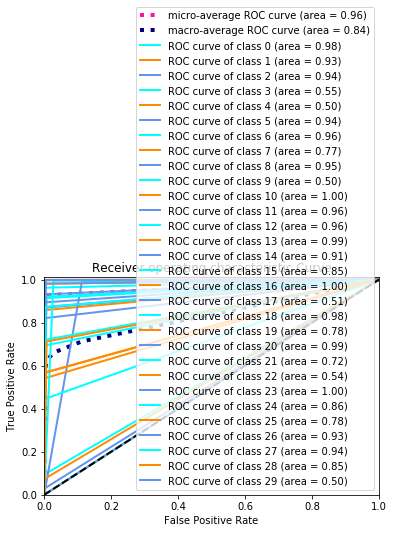

In [194]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
dt_expected = y_test
# y_prob = ovr.predict_proba(X_test)
n_classes = y_test.shape[1]
#  Compute ROC curve and ROC area for each class
# dt_expected_new = label_binarize(dt_expected, classes = pd.Series(y).unique())
# dt_predicted_new = label_binarize(dt_predicted, classes = pd.Series(y).unique())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [195]:
roc_auc["macro"]

0.8351470533646926

In [196]:
roc_auc["micro"]

0.9623003276417895